In [16]:
import numpy as np
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import backend as K
import os
from IPython.display import Image

# location to cache the model weights
autoencoder_file = "weights/ch_3_autoencoder_model_weights.h5"
encoder_file = "weights/ch_3_encoder_model_weights.h5"

(x_train,y_train), (x_test,y_test) = datasets.fashion_mnist.load_data()

def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [17]:
# Q: its interesting that encoder models are convolutional layers, can you make encoder models from dense layers instead?
# A: yes that can work, convolutions just usually work better on images due to their filters approach that can detect edges etc (gets structure of obj)
#    dense is often used for non image data like text etc

# Q: why is the input of each conv layer increasing from 32, 64, 128?
# A: first layers might learn simple features like edges and textures, while deeper layers can learn more complex features like shapes and objects

# Q: what exactly does it mean by 32, ... 128? Is the image getting bigger? Is there a way to "show" what happens to the image at each step on a sample image?

# Q: can you do this with just 1 conv layer? how about 2? what determines the # of conv layers to use?

# Q: what's the size of the "embedding" (aka the array) from layers.Flatten?
# A: 128x128 => 16,384

# Q: what's the purpose of the dense layer at the end? wouldn't that make the output from the encoder not a flat array?

# build the encoder model
encoder_input = layers.Input(
    shape=(32, 32, 1), name = "encoder_input"
) 
x = layers.Conv2D(32, (3, 3), strides = 2, activation = 'relu', padding="same")(
    encoder_input
) 
x = layers.Conv2D(64, (3, 3), strides = 2, activation = 'relu', padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides = 2, activation = 'relu', padding="same")(x)

shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x) 

encoder_output = layers.Dense(2, name="encoder_output")(x) 

encoder = models.Model(encoder_input, encoder_output)

In [18]:
# Q: whats the transpose for? what does a matrix times its transpose do to the output?

# Q: is "reshape" the opposite of "flatten"?

# Q: what's the point of decoder output? what does that do? 

# Q: whats the output after 32 Conv2DTranspose? how do
# build the decoder model
decoder_input = layers.Input(shape=(2,), name="decoder_input") 

x = layers.Dense(np.prod(shape_before_flattening))(decoder_input) 

x = layers.Reshape(shape_before_flattening)(x) 

x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation = 'relu', padding="same"
)(x) 

x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation = 'relu', padding="same"
)(x)

x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation = 'relu', padding="same"
)(x)

decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides = 1,
    activation="sigmoid",
    padding="same",
    name="decoder_output"
)(x)

decoder = models.Model(decoder_input, decoder_output)

In [19]:
autoencoder = models.Model(encoder_input, decoder(encoder_output))

# Q: how does binary_crossentropy loss function differ from the typical RMSE (root mean squared error)?
# Compile the autoencoder
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

if os.path.exists(autoencoder_file) and os.path.exists(encoder_file):
    # Load the pre-trained model, welp the encoder, decoder, compile parts a bit useless in this case...
    autoencoder = models.load_model(autoencoder_file)
    encoder = models.load_model(encoder_file)
    print("Loaded saved model from disk.")
else:
    # Train the model because it hasn't been trained yet
    print("Training the model...")
    autoencoder.fit(
        x_train,
        x_train,
        epochs=5,
        batch_size=100,
        shuffle=True,
        validation_data=(x_test, x_test),
    )
    
    # Save the model for future use
    autoencoder.save(autoencoder_file)
    encoder.save(encoder_file)
    print(f"Autoencoder model saved to {autoencoder_file}.")
    print(f"Encoder model saved to {encoder_file}.")

Loaded saved model from disk.


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


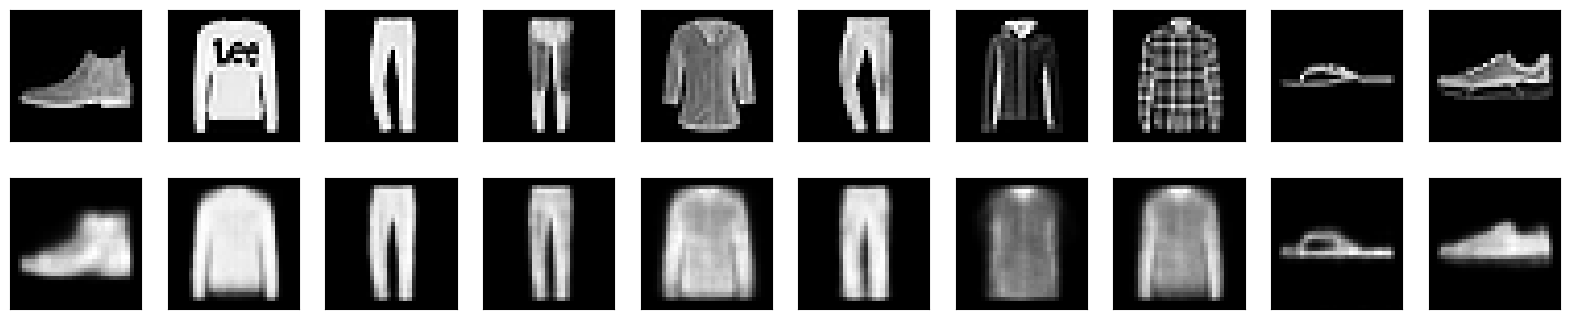

In [20]:
# run inference on some
example_images = x_test[:5000]
predictions = autoencoder.predict(example_images)

# display
import matplotlib.pyplot as plt

# Assuming you have your original images in `example_images`
# and your predictions in `predictions`

n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(example_images[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed images (predictions)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i].reshape(32, 32))  # Adjust the shape based on your dataset
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


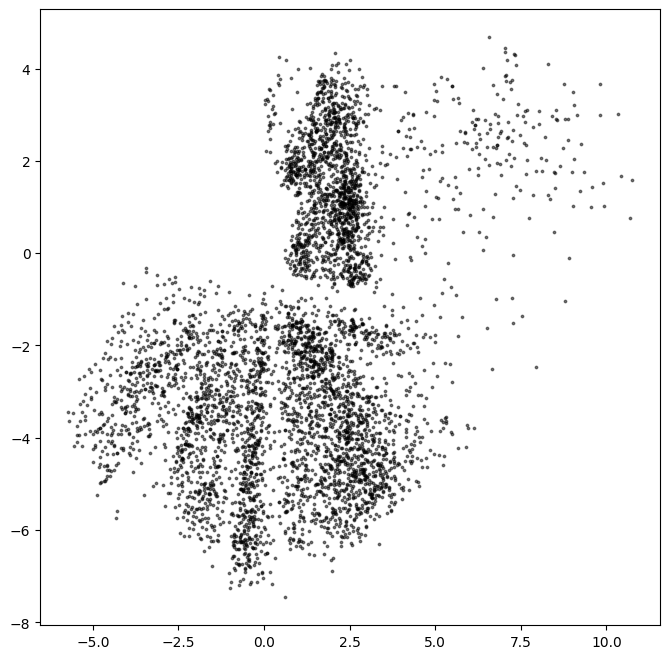

In [21]:
# embed/encode the images (without runing decoder) and show the latent space
embeddings = encoder.predict(example_images)

plt.figure(figsize=(8, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

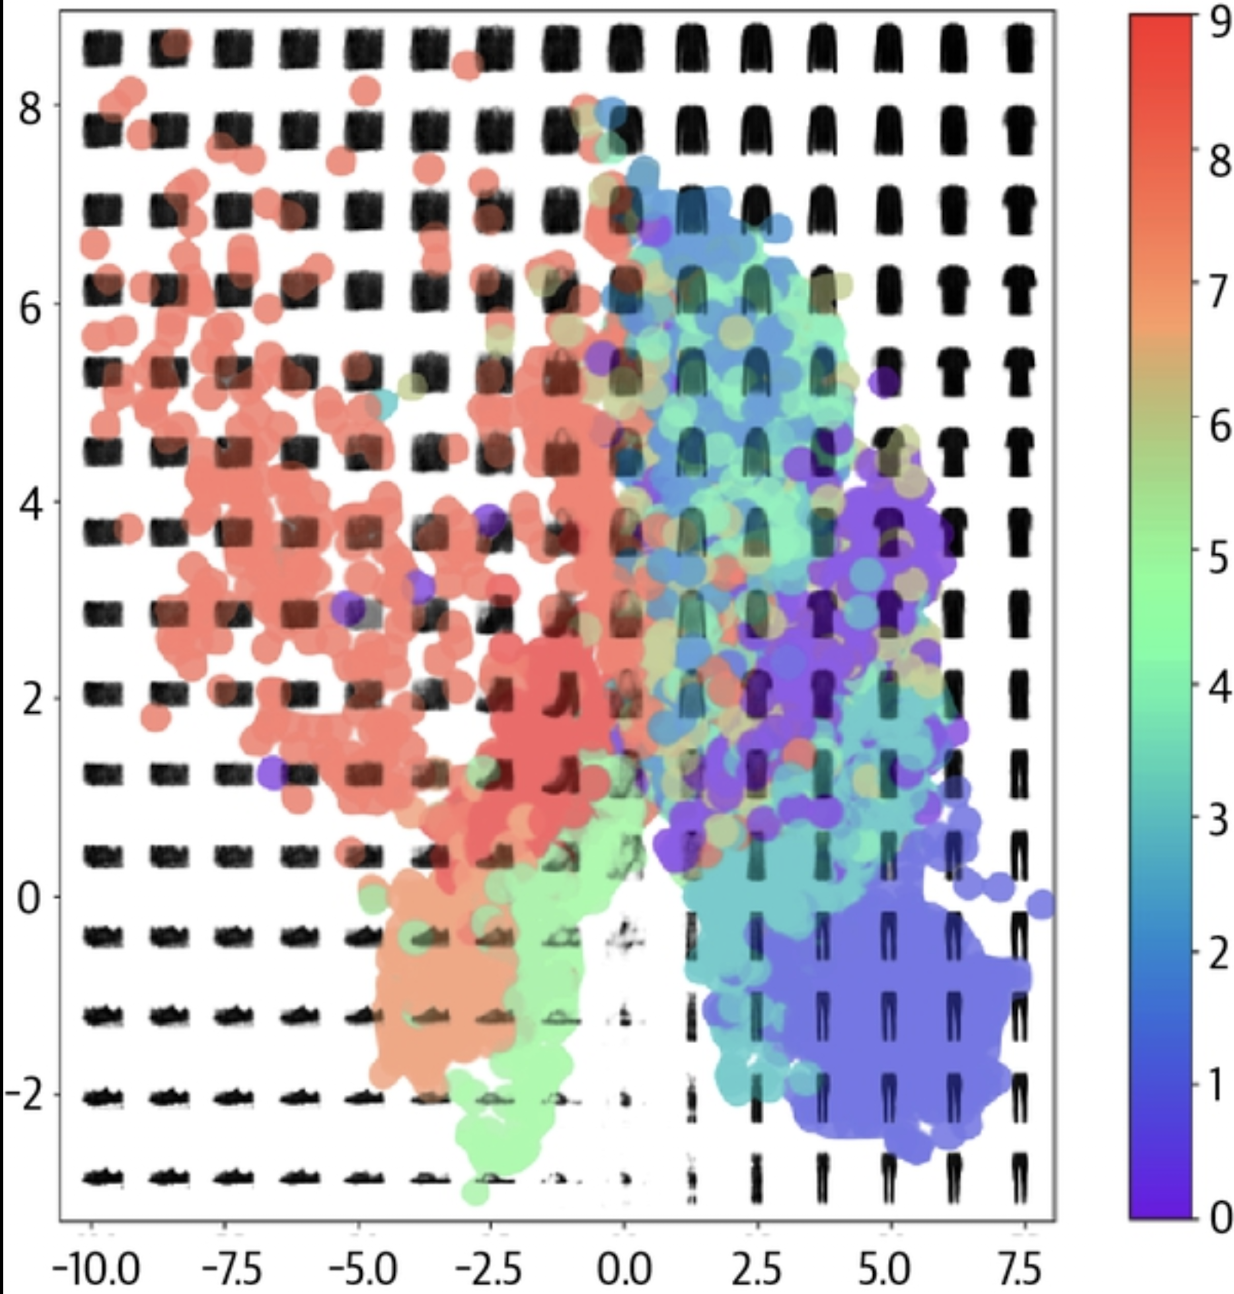

In [22]:
# i wish i can just make this overlay myself but for the sake of time, just going to show an image
# notice how the categories of clothing are in sections within the latent space
Image(filename='images/autoencoder_clothing_latent_space_overlay.png', width=500)